In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Data Preprocessing

In [47]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [48]:
true['label'] = 'True'
fake['label'] = 'Fake'

In [49]:
fake.shape

(23481, 5)

In [50]:
true.shape

(21417, 5)

In [51]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [52]:
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [53]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,label
0,RIYADH (Reuters) - U.S. President Donald Trump...,worldnews,True
1,NEW YORK (Reuters) - Islamic State has claimed...,politicsNews,True
2,SANTIAGO (Reuters) - A group of opposition-app...,worldnews,True
3,A new poll conducted in South Carolina on the ...,News,Fake
4,Debate officials have released the details of ...,left-news,Fake


In [54]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,label
0,riyadh (reuters) - u.s. president donald trump...,worldnews,True
1,new york (reuters) - islamic state has claimed...,politicsNews,True
2,santiago (reuters) - a group of opposition-app...,worldnews,True
3,a new poll conducted in south carolina on the ...,News,Fake
4,debate officials have released the details of ...,left-news,Fake


In [55]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [56]:
data['text'] = data['text'].apply(punctuation_removal)

In [57]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\moyank
[nltk_data]     giri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


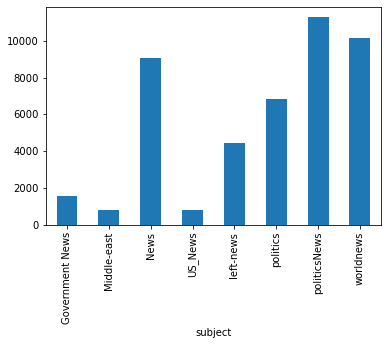

In [58]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
Fake    23481
True    21417
Name: text, dtype: int64


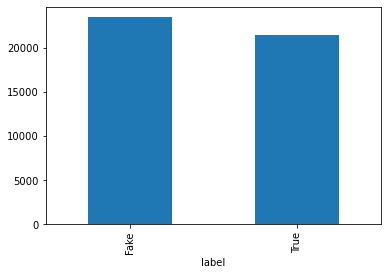

In [59]:
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

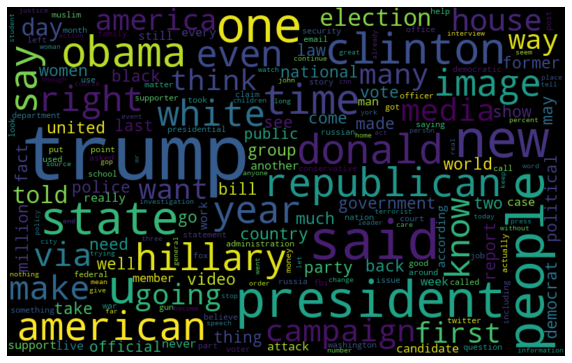

In [60]:
from wordcloud import WordCloud

fake_data = data[data["label"] == "Fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

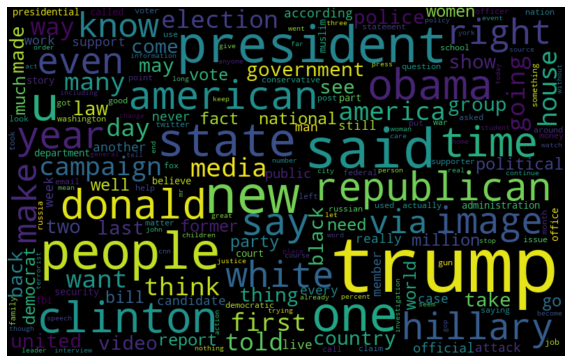

In [61]:
real_data = data[data["label"] == "True"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

# to find most frequent words of some category
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

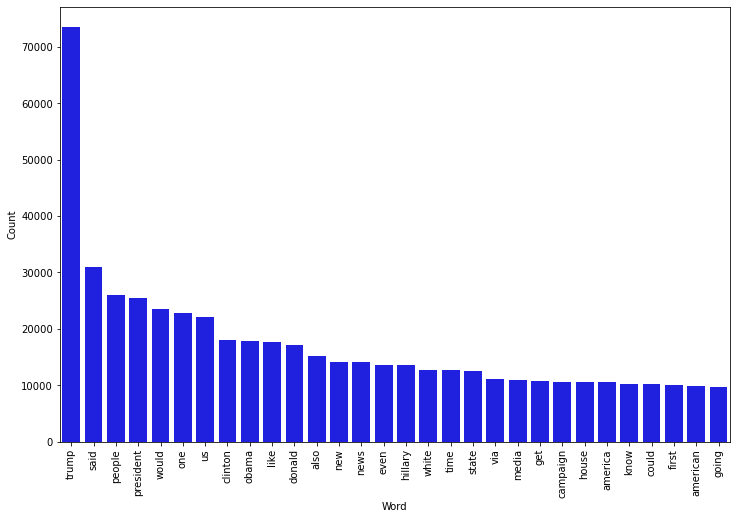

In [63]:
counter(data[data["label"] == "Fake"], "text", 30)

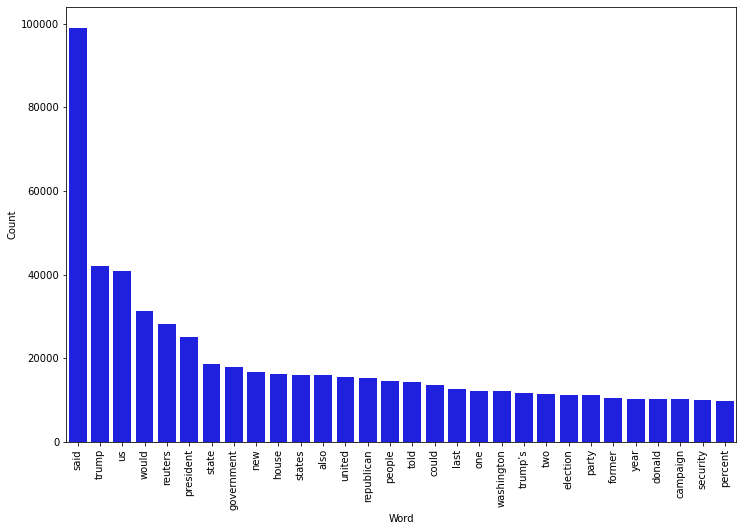

In [64]:
counter(data[data["label"] == "True"], "text", 30)

In [65]:
from sklearn import metrics
import itertools

# to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Splitting the dataset into training and testing sets

In [66]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=1)

# Models training and testing

### Model 1: Decision Tree 

In [67]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',max_depth = 20, splitter='best', random_state=1))])
# Fitting the model
model_dt = pipe.fit(X_train, y_train)

# Accuracy
prediction = model_dt.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.62%


Confusion matrix, without normalization


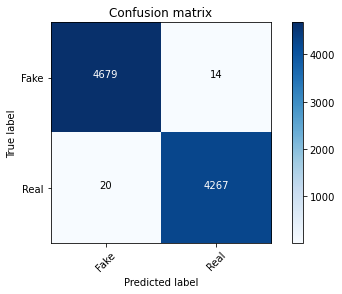

In [68]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

As seen above we can get the following insights:
1. There are 4679 cases where model predicted fake and news was fake
2. There are 4267 cases where model predicted true and news was true
3. There are 20 cases where the model predicted false while the news was true
4. There are 14 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>99.62%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

In [69]:
# Saving the model for future uses
import pickle
filename_dt = 'Saved_Models/FakeNews_DecisionTree.sav'
pickle.dump(model, open(filename_dt, 'wb'))

### Model 2: Random Forest Classifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model_rfc = pipe.fit(X_train, y_train)
prediction = model_rfc.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.08%


Confusion matrix, without normalization


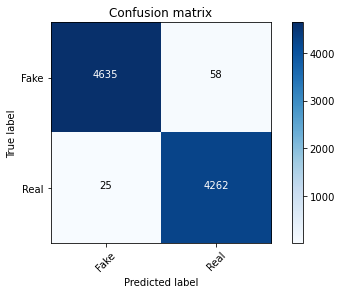

In [71]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

As seen above we can get the following insights:
1. There are 4635 cases where model predicted fake and news was fake
2. There are 4262 cases where model predicted true and news was true
3. There are 25 cases where the model predicted false while the news was true
4. There are 58 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>99.08%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

In [72]:
import pickle
filename_rfc = 'Saved_Models/FakeNews_RandomForestClassifier.sav'
pickle.dump(model, open(filename_rfc, 'wb'))

### Multinomial Naive Bayes

In [74]:
from sklearn.naive_bayes import MultinomialNB
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model_nb = pipe.fit(X_train, y_train)
prediction = model_nb.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.3%


Confusion matrix, without normalization


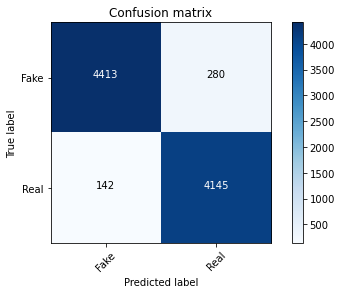

In [75]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

As seen above we can get the following insights:
1. There are 4413 cases where model predicted fake and news was fake
2. There are 4145 cases where model predicted true and news was true
3. There are 142 cases where the model predicted false while the news was true
4. There are 280 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>95.30%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

In [77]:
import pickle
filename_nb = 'Saved_Models/FakeNews_MultinomialNaiveBayes.sav'
pickle.dump(model, open(filename_nb, 'wb'))

In [78]:
'''
# load the model from disk
news_article = ''
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(news_article)
'''

"\n# load the model from disk\nnews_article = ''\nloaded_model = pickle.load(open(filename, 'rb'))\nresult = loaded_model.predict(news_article)\n"